In [2]:
# from diffusers import UNet2DConditionModel
# import torch, torch.fx as fx

# CKPT = "prs-eth/marigold-depth-v1-1"

# # 1️⃣  Disable every fused/compiled attention path
# import torch.backends.cuda as bk
# bk.enable_flash_sdp(False); bk.enable_mem_efficient_sdp(False)

# unet = UNet2DConditionModel.from_pretrained(
#           CKPT, subfolder="unet",
#           low_cpu_mem_usage=True).cpu()

# # diffusers >=0.23 has an explicit helper too
# unet.disable_xformers_memory_efficient_attention()   # no-op if xformers absent :contentReference[oaicite:0]{index=0}

# # 2️⃣  Optional: treat Transformer blocks as leafs so the graph stays small
# class DiffusersTracer(fx.Tracer):
#     def is_leaf_module(self, m, qualname):
#         if "Transformer2DModel" in m.__class__.__name__:
#             return True
#         return super().is_leaf_module(m, qualname)

# tracer = DiffusersTracer()
# gm = tracer.trace(unet)

# gm.graph.print_tabular()          # quick visual check
# gm.recompile()                    # be sure the new GraphModule runs


## this uses the new p2e prepare and wunatize kep this code for usage but it actualy doesnt server nay ppurpose for now, it jsut shows they full progression

In [ ]:
import torch
from diffusers import UNet2DConditionModel
from torch.export import export
from torch.ao.quantization.qconfig_mapping import (
    get_default_qat_qconfig_mapping)
from torch.ao.quantization.quantize_pt2e import (
    prepare_qat_pt2e, convert_pt2e)
import torch, inspect
from torch.ao.quantization.quantize_pt2e import prepare_qat_pt2e
print("torch:", torch.__version__)
print(inspect.signature(prepare_qat_pt2e))

CKPT = "prs-eth/marigold-depth-v1-1"
unet = UNet2DConditionModel.from_pretrained(CKPT, subfolder="unet").cpu()
unet.disable_xformers_memory_efficient_attention()

example = (torch.randn(1, 8, 64, 64),     # latent
           torch.tensor([0]),             # timestep
           torch.randn(1, 77, 1024))      # text enc

gm = export(unet, example)                # records the loop as guards
qmap = get_default_qat_qconfig_mapping("x86")
gm_qat = prepare_qat_pt2e(gm, qmap)
# fine-tune ...
gm_int8 = convert_pt2e(gm_qat)
gm_int8.save("unet_int8.pt")



## Torch export for unet graph tracing and saving

In [1]:
import torch
from diffusers import UNet2DConditionModel
from torch.export import export, save
from torch.export import ExportedProgram
# working
CKPT  = "prs-eth/marigold-depth-v1-1"
unet  = UNet2DConditionModel.from_pretrained(CKPT, subfolder="unet").cpu()
unet.disable_xformers_memory_efficient_attention()

example = (
    torch.randn(1, 8, 64, 64),   # latent
    torch.tensor([0]),           # timestep
    torch.randn(1, 77, 1024)     # text enc
)

gm_unet: ExportedProgram = export(unet, example)
save(gm_unet, "unet_fp32.ep")
gm_unet.graph.print_tabular()


# gm_unet = export(unet, example)       # ← this is already a GraphModule
# gm_unet.graph.print_tabular()         # nicely formatted table
# # or:
# print(gm_unet.graph)                  # raw ATen graph

# save(gm_unet, "unet_fp32.ep") 

/home/abradshaw/Marigold/venv/marigold/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


opcode         name                                                                     target                                                                   args                                                                                                                                                           kwargs
-------------  -----------------------------------------------------------------------  -----------------------------------------------------------------------  -------------------------------------------------------------------------------------------------------------------------------------------------------------  ---------------------------------------------------------------------------
placeholder    p_time_embedding_linear_1_weight                                         p_time_embedding_linear_1_weight                                         ()                                                                                                                  

## swap out the unsupported ops from the unet

In [3]:
unsupported_ops = set()
for node in gm_unet.graph.nodes:
    if node.op == "call_function" and "quant" not in str(node.target):
        # Add your own conditions here if targeting quantization
        unsupported_ops.add(str(node.target))

print("Unsupported/Custom Ops to Handle:")
print(unsupported_ops)

Unsupported/Custom Ops to Handle:
{'aten.conv2d.default', 'aten.gelu.default', 'aten.dropout.default', 'aten.unsqueeze.default', 'aten.cat.default', 'aten.layer_norm.default', 'aten.silu.default', 'aten.div.Tensor', 'aten.sin.default', 'aten.clone.default', 'aten.linear.default', 'aten.group_norm.default', 'aten.upsample_nearest2d.vec', 'aten.expand.default', 'aten.cos.default', 'aten._to_copy.default', 'aten.permute.default', 'aten.transpose.int', 'aten.mul.Tensor', 'aten.slice.Tensor', 'aten.add.Tensor', 'aten.exp.default', 'aten.view.default', 'aten.split.Tensor', 'aten.scaled_dot_product_attention.default', '<built-in function getitem>', 'aten.arange.start'}


## This is for comaporing the graph module with the origional model (UNET)

In [2]:
from torch.export import load

# 1. load the exported program
ep = load("unet_fp32.ep")

# 2. get the GraphModule that does the work
gm = ep.module()          # <-- now it's an ordinary nn.Module

# 3. run the same inputs you used for export
example = (
    torch.randn(1, 8, 64, 64),   # latent
    torch.tensor([0]),           # timestep
    torch.randn(1, 77, 1024)     # text enc
)

out1 = gm(*example)       # exported graph
out2 = unet(*example)     # original eager model

print("max |Δ| =", (out1.sample - out2.sample).abs().max())



/home/abradshaw/Marigold/venv/marigold/lib/python3.10/site-packages/torch/_export/serde/serialize.py:317: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  artifact = torch.load

max |Δ| = tensor(0., grad_fn=<MaxBackward1>)


## another way that the implmnetnation works

In [ ]:
# import importlib
# import torch
# from diffusers import UNet2DConditionModel
# from torch.export import export, save
# from torch.utils._pytree import (
#     register_pytree_node, SUPPORTED_NODES   # SUPPORTED_NODES = current registry
# )

# # ------------------------------------------------------------------
# # 1) Locate UNet2DConditionOutput regardless of diffusers version
# # ------------------------------------------------------------------
# def _find_unet_output_class():
#     # new layout (>=0.24)
#     try:
#         return importlib.import_module(
#             "diffusers.models.unets.unet_2d_condition"
#         ).UNet2DConditionOutput
#     except (ModuleNotFoundError, AttributeError):
#         pass
#     # old layout (<=0.23)
#     try:
#         return importlib.import_module(
#             "diffusers.models.unet_2d_condition"
#         ).UNet2DConditionOutput
#     except (ModuleNotFoundError, AttributeError):
#         pass
#     raise RuntimeError("Could not locate UNet2DConditionOutput")

# UNet2DConditionOutput = _find_unet_output_class()

# # ------------------------------------------------------------------
# # 2) Register as a pytree **only if not registered yet**
# # ------------------------------------------------------------------
# if UNet2DConditionOutput not in SUPPORTED_NODES:
#     def _flatten(o: UNet2DConditionOutput):
#         return ((o.sample,), None)      # children, context

#     def _unflatten(ctx, children):
#         (sample,) = children
#         return UNet2DConditionOutput(sample=sample)

#     register_pytree_node(
#         UNet2DConditionOutput, _flatten, _unflatten,
#         serialized_type_name="UNet2DConditionOutput"
#     )

# # ------------------------------------------------------------------
# # 3) Load the fp32 UNet
# # ------------------------------------------------------------------
# CKPT = "prs-eth/marigold-depth-v1-1"
# unet = UNet2DConditionModel.from_pretrained(CKPT, subfolder="unet").cpu()
# unet.disable_xformers_memory_efficient_attention()   # avoid un-exportable ops
# unet.eval()

# # ------------------------------------------------------------------
# # 4) Example inputs (realistic shapes)
# # ------------------------------------------------------------------
# example_inputs = (
#     torch.randn(1, 8, 64, 64),   # latent
#     torch.tensor([0]),           # timestep
#     torch.randn(1, 77, 1024)     # text embedding
# )

# # ------------------------------------------------------------------
# # 5) Export  ➜  ExportedProgram  ➜  .ep file
# # ------------------------------------------------------------------
# ep = export(unet, example_inputs)
# save(ep, "unet_fp32.ep")

# print("✅  Exported UNet saved to: unet_fp32.ep")


/home/abradshaw/Marigold/venv/marigold/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅  Exported UNet saved to: unet_fp32.ep


In [10]:
# Find ops that lack a quantisation pattern
from torch.fx.passes.graph_draw import FxGraphDrawer
 
unsupported = []
for n in gm.graph.nodes:
    if n.op == "call_function":
        # Replace with your backend's supported op list
        if n.target not in torch._inductor.lowering._registered_ops:
            unsupported.append(n.target)

print("Ops with no Inductor lowering:", set(unsupported))
# view the graph visually
FxGraphDrawer(gm, "unet").run()  


ModuleNotFoundError: No module named 'torch.fx.passes.graph_draw'

In [ ]:
# hwhe nweneed ot wuanitze
from torch.ao.quantization.qconfig_mapping import get_default_qat_qconfig_mapping
from torch.ao.quantization.quantizer import X86InductorQuantizer
from torch.ao.quantization.quantize_pt2e import prepare_qat_pt2e, convert_pt2e

qmap      = get_default_qat_qconfig_mapping("x86")
quantizer = X86InductorQuantizer().set_global(qmap)

gm_qat = prepare_qat_pt2e(gm, quantizer)   # inserts fake-quant nodes
# … fine-tune gm_qat for a few epochs …
gm_int8 = convert_pt2e(gm_qat)
gm_int8.save("unet_int8.pt")


In [ ]:
# import torch
# from diffusers import AutoencoderKL
# from torch.export import export
# import inspect

# CKPT = "prs-eth/marigold-depth-v1-1"

# vae = AutoencoderKL.from_pretrained(CKPT, subfolder="vae").cpu()
# vae.eval()                                   # switch off dropout
# class VAEEncodeDecode(torch.nn.Module):
#     def __init__(self, core):
#         super().__init__()
#         self.core = core
#     def forward(self, x):
#         # Encode RGB → latent
#         lat = self.core.encode(x).latent_dist.sample()
#         # Decode latent → reconstruction
#         img = self.core.decode(lat).sample
#         return lat, img            # returns a tuple

# wrapper = VAEEncodeDecode(vae)
# rgb = torch.randn(1, 3, 512, 512)
# gm = export(wrapper, (rgb,))        # gm is already a GraphModule
# gm.graph.print_tabular()            # pretty table
# # or just:
# print(gm.graph)                   # raw text




opcode         name                                                              target                                                            args                                                                                                                                                            kwargs
-------------  ----------------------------------------------------------------  ----------------------------------------------------------------  --------------------------------------------------------------------------------------------------------------------------------------------------------------  ------------------------------------------
placeholder    p_encoder_conv_in_weight                                          p_encoder_conv_in_weight                                          ()                                                                                                                                                              {}
placeholder    p_encoder_c

## VAE implemenation fo F32graph saving before ops

In [4]:
import torch
from diffusers import AutoencoderKL
from torch.export import export

vae = AutoencoderKL.from_pretrained(
        "prs-eth/marigold-depth-v1-1", subfolder="vae").cpu().eval()

rgb = torch.randn(1, 3, 512, 512)

# AutoencoderKL.forward does: encode → (optionally sample) → decode
gm_vae = export(vae, (rgb,))            # default sample_posterior = False
gm_vae.graph.print_tabular()            # full encoder + decoder graph
print(gm_vae.graph)

save(gm_vae, "vae_fp32.ep")
print("VAE exported ➜  vae_fp32.ep")

opcode         name                                                              target                                                            args                                                                                                                                                            kwargs
-------------  ----------------------------------------------------------------  ----------------------------------------------------------------  --------------------------------------------------------------------------------------------------------------------------------------------------------------  ------------------------------------------
placeholder    p_encoder_conv_in_weight                                          p_encoder_conv_in_weight                                          ()                                                                                                                                                              {}
placeholder    p_encoder_c

## this is for comaporing the graph module with the origional model (VAE)

In [9]:
ep_loaded = load("vae_fp32.ep")   # the ExportedProgram

gm = ep_loaded.module()           # ← call with no args, returns GraphModule
out_graph = gm(rgb)               # run the graph
out_eager = vae(rgb)              # original eager result

print("max |Δ| =", (out_graph.sample - out_eager.sample).abs().max())  # ≈ 0


max |Δ| = tensor(0., grad_fn=<MaxBackward1>)


In [1]:
import torch, torchvision
print("torch :", torch.__version__,  "|  CUDA runtime", torch.version.cuda)
print("tv    :", torchvision.__version__, "|  compiled w/ CUDA:",
      torchvision._is_tracing() is not None or torchvision._is_compiled_with_cuda())  # True means CUDA kernels present
print("GPU   :", torch.cuda.get_device_name(), torch.cuda.get_device_capability())

torch : 2.4.1+cu121 |  CUDA runtime 12.1


AttributeError: module 'torchvision' has no attribute '_is_compiled_with_cuda'

In [2]:
import os, torch, numpy as np
from marigold.marigold_depth_pipeline import MarigoldDepthPipeline
from diffusers import DDIMScheduler
from omegaconf import OmegaConf
from src.dataset import DatasetMode, get_dataset
from src.util.alignment import align_depth_least_square
from torchvision.transforms.functional import to_pil_image
from scipy.stats import pearsonr

# 0️⃣ Pin to GPU 1
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
torch.cuda.set_device(1)
device = torch.device("cuda")

# 1️⃣ Load pipeline + fine‑tuned UNet
ckpt_root  = "/home/abradshaw/Marigold/output/train_marigold_depth/checkpoint/latest"
base_model = "prs-eth/marigold-depth-v1-1"
dtype = torch.float16           # <-- only change

pipe = MarigoldDepthPipeline.from_pretrained(base_model,
                                             torch_dtype=dtype)

pipe.unet = pipe.unet.__class__.from_pretrained(
    os.path.join(ckpt_root, "unet"), torch_dtype=dtype
)

pipe.scheduler = DDIMScheduler.from_pretrained(
    os.path.join(ckpt_root, "scheduler")
)

pipe = pipe.to(device, dtype=dtype)      # make sure VAE & UNet are fp16

# 2️⃣ Load one sample
cfg = OmegaConf.load("/home/abradshaw/Marigold/config/dataset_depth/data_hypersim_val.yaml")
ds  = get_dataset(cfg, base_data_dir="/home/abradshaw/marigold_data", mode=DatasetMode.EVAL)
sample     = ds[0]
rgb_pil    = to_pil_image(sample["rgb_int"].to(torch.uint8))
gt_depth   = sample["depth_raw_linear"].numpy()      # shape (1,H,W) or (H,W)
valid_mask = sample["valid_mask_raw"].numpy()         # (H,W) or (1,H,W)

# 3️⃣ Inference
with torch.no_grad():
    pred = pipe(rgb_pil, show_progress_bar=False).depth_np  # shape (1,H,W)

 # ─────────── Squeeze to 2D ───────────
pred_depth = np.squeeze(pred)        # (H, W)
gt_depth   = np.squeeze(gt_depth)    # (H, W)  ← ADD THIS LINE
valid_mask = np.squeeze(valid_mask)  # (H, W)
 # ──────────────────────────────────────

print("shapes:", pred_depth.shape, gt_depth.shape, valid_mask.shape)
print("dtype:", pred_depth.dtype)
# 1) NaN / Inf counts
print(" any NaN:", np.isnan(pred_depth).sum(),
      " any Inf:", np.isinf(pred_depth).sum())
# 2) how many valid pixels?
print(" valid-mask count:", valid_mask.sum(), "/", valid_mask.size)

 # 4️⃣ Flatten over valid pixels
assert pred_depth.shape == gt_depth.shape == valid_mask.shape, (
    f"shapes mismatch: pred {pred_depth.shape},  gt {gt_depth.shape},  mask {valid_mask.shape}"
)

pred_vals = pred_depth[valid_mask]
gt_vals   = gt_depth[valid_mask]

# 5️⃣ Basic summary stats
print("PRED min/max/mean/std:",
      f"{pred_vals.min():.3f}/"
      f"{pred_vals.max():.3f}/"
      f"{pred_vals.mean():.3f}/"
      f"{pred_vals.std():.3f}")
print(" GT  min/max/mean/std:",
      f"{gt_vals.min():.3f}/"
      f"{gt_vals.max():.3f}/"
      f"{gt_vals.mean():.3f}/"
      f"{gt_vals.std():.3f}")

# 6️⃣ MAE & RMSE
errors = pred_vals - gt_vals
mae  = np.mean(np.abs(errors))
rmse = np.sqrt(np.mean(errors**2))
print(f" MAE: {mae:.3f}   RMSE: {rmse:.3f}")

# 7️⃣ δ‐accuracies
ratio = np.maximum(pred_vals/gt_vals, gt_vals/pred_vals)
for δ in [1.25, 1.25**2, 1.25**3]:
    print(f" δ<{δ:.2f}:", f"{(ratio<δ).mean():.2%}")

# 8️⃣ Pearson r
r, _ = pearsonr(gt_vals, pred_vals)
print(f" Pearson r: {r:.4f}")

# 9️⃣ LS‐alignment (as before)
try:
    aligned, s, t = align_depth_least_square(
        gt_depth, pred_depth, valid_mask,
        return_scale_shift=True, max_resolution=960
    )
    print("alignment OK – scale", s, "shift", t)
except np.linalg.LinAlgError as e:
    print("LS failure:", e)


The config attributes {'prediction_type': 'depth', 'text_encoder': ['transformers', 'CLIPTextModel'], 'tokenizer': ['transformers', 'CLIPTokenizer']} were passed to MarigoldDepthPipeline, but are not expected and will be ignored. Please verify your model_index.json configuration file.
Keyword arguments {'prediction_type': 'depth', 'text_encoder': ['transformers', 'CLIPTextModel'], 'tokenizer': ['transformers', 'CLIPTokenizer']} are not expected by MarigoldDepthPipeline and will be ignored.
Loading pipeline components...: 100%|██████████| 3/3 [00:00<00:00,  3.86it/s]


shapes: (768, 1024) (768, 1024) (768, 1024)
dtype: float16
 any NaN: 786432  any Inf: 0
 valid-mask count: 786432 / 786432
PRED min/max/mean/std: nan/nan/nan/nan
 GT  min/max/mean/std: 1.507/13.708/5.214/2.434
 MAE: nan   RMSE: nan
 δ<1.25: 0.00%
 δ<1.56: 0.00%
 δ<1.95: 0.00%
 Pearson r: nan


TypeError: array type float16 is unsupported in linalg

In [20]:
print("scheduler:", type(pipe.scheduler))
print("  rescale_betas_zero_snr =", pipe.scheduler.config.rescale_betas_zero_snr)
print("  timestep_spacing       =", pipe.scheduler.config.timestep_spacing)
print("  betas[0:3]             =", pipe.scheduler.betas[:3])

print("unet conv_in:", pipe.unet.conv_in.weight.shape)   # should be (320, 8, 3, 3)
print("unet dtype  :", pipe.unet.dtype)

scheduler: <class 'diffusers.schedulers.scheduling_ddim.DDIMScheduler'>
  rescale_betas_zero_snr = True
  timestep_spacing       = trailing
  betas[0:3]             = tensor([0.0009, 0.0009, 0.0009])
unet conv_in: torch.Size([320, 8, 3, 3])
unet dtype  : torch.float32


In [3]:
import numpy as np, torch, json, random
from tqdm.auto import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch
# now tell PyTorch “use the first visible device”
torch.cuda.set_device(1)
stats = {
    "n_total"      : len(ds),
    "n_ok"         : 0,
    "n_zero_mask"  : 0,         # valid_mask.sum()==0
    "n_nan_inf"    : 0,         # contains NaN / Inf
    "min_depth"    :  1e9,
    "max_depth"    : -1e9,
}
bad_indices = []

for i in tqdm(range(100), desc="Scanning depth maps"):
    s          = ds[i]
    depth_np   = s["depth_raw_linear"].numpy()
    valid_mask = s["valid_mask_raw"].numpy()

    # 1. check finite values
    if not np.isfinite(depth_np).all():
        stats["n_nan_inf"] += 1
        bad_indices.append((i,"nan/inf"))
        continue

    # 2. check mask
    if valid_mask.sum() == 0:
        stats["n_zero_mask"] += 1
        bad_indices.append((i,"zero_mask"))
        continue

    stats["n_ok"] += 1
    stats["min_depth"] = min(stats["min_depth"], float(depth_np[valid_mask].min()))
    stats["max_depth"] = max(stats["max_depth"], float(depth_np[valid_mask].max()))

print(json.dumps(stats, indent=2))
print("first 10 bad indices:", bad_indices[:10])

Scanning depth maps: 100%|██████████| 100/100 [00:04<00:00, 23.93it/s]

{
  "n_total": 7370,
  "n_ok": 100,
  "n_zero_mask": 0,
  "n_nan_inf": 0,
  "min_depth": 0.23999999463558197,
  "max_depth": 15.097999572753906
}
first 10 bad indices: []


In [7]:
# %% [markdown]
# ## Single‐Cell Evaluation & Metrics Visualization
# Runs one validation sample through your fine‐tuned Marigold pipeline,
# then computes a battery of depth‐error metrics and visualizations.

# %%
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from marigold.marigold_depth_pipeline import MarigoldDepthPipeline
from diffusers import DDIMScheduler
from omegaconf import OmegaConf
from src.dataset import DatasetMode, get_dataset
from torchvision.transforms.functional import to_pil_image

# 1️⃣ Environment & Device
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
torch.cuda.set_device(1)                              # first visible device → GPU 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2️⃣ Load Pipeline & Fine‑Tuned Checkpoint
base_model = "prs-eth/marigold-depth-v1-1"
ckpt_root  = "/home/abradshaw/Marigold/output/train_marigold_depth/checkpoint/latest"
pipe = MarigoldDepthPipeline.from_pretrained(base_model, torch_dtype=torch.float32)
pipe.unet = pipe.unet.__class__.from_pretrained(
    os.path.join(ckpt_root, "unet"),
    torch_dtype=torch.float32
)
pipe.scheduler = DDIMScheduler.from_pretrained(os.path.join(ckpt_root, "scheduler"))
pipe = pipe.to(device)

# 3️⃣ Prepare One Validation Sample
cfg = OmegaConf.load("/home/abradshaw/Marigold/config/dataset_depth/data_hypersim_val.yaml")
ds  = get_dataset(cfg, base_data_dir="/home/abradshaw/marigold_data", mode=DatasetMode.EVAL)
sample      = ds[0]
rgb_pil     = to_pil_image(sample["rgb_int"].to(torch.uint8))
gt_depth    = sample["depth_raw_linear"].numpy()       # (H, W)
valid_mask  = sample["valid_mask_raw"].numpy().astype(bool)

# 4️⃣ Run Inference
with torch.no_grad():
    pred = pipe(rgb_pil, show_progress_bar=False).depth_np  # shape (1,H,W)
pred_depth = np.squeeze(pred)                             # shape (H, W)

# 5️⃣ Mask & Flatten
assert pred_depth.shape == gt_depth.shape == valid_mask.shape
pred_vals = pred_depth[valid_mask]
gt_vals   = gt_depth[valid_mask]

# 6️⃣ Basic Summary Statistics
print(f"PRED  → min {pred_vals.min():.3f}, max {pred_vals.max():.3f}, "
      f"mean {pred_vals.mean():.3f}, std {pred_vals.std():.3f}")
print(f"GT    → min {gt_vals.min():.3f}, max {gt_vals.max():.3f}, "
      f"mean {gt_vals.mean():.3f}, std {gt_vals.std():.3f}")

# 7️⃣ Percentiles
for p in [1, 5, 25, 50, 75, 95, 99]:
    print(f"PRED {p}th percentile: {np.percentile(pred_vals, p):.3f}")

# 8️⃣ Correlation
r, _ = pearsonr(gt_vals, pred_vals)
print(f"Pearson r: {r:.4f}")

# 9️⃣ Error Metrics: MAE, RMSE, SILog
errors = pred_vals - gt_vals
mae  = np.mean(np.abs(errors))
rmse = np.sqrt(np.mean(errors**2))
d    = np.log(pred_vals + 1e-6) - np.log(gt_vals + 1e-6)
silog= np.sqrt(np.mean(d**2) - 0.85*(np.mean(d))**2)
print(f"MAE: {mae:.3f} m,  RMSE: {rmse:.3f} m,  SILog: {silog:.3f}")

# 1️⃣0️⃣ Threshold Accuracies δ<1.25,1.25²,1.25³
ratio = np.maximum(pred_vals/gt_vals, gt_vals/pred_vals)
for d in [1.25, 1.25**2, 1.25**3]:
    print(f"δ<{d:.3f}: {np.mean(ratio<d):.3%}")

# 1️⃣1️⃣ Plots

# a) Scatter plot GT vs PRED
idx = np.random.choice(len(pred_vals), size=5000, replace=False)
plt.figure(figsize=(5,5))
plt.scatter(gt_vals[idx], pred_vals[idx], s=1, alpha=0.1)
mn, mx = gt_vals.min(), gt_vals.max()
plt.plot([mn,mx], [mn,mx], 'r--', lw=1)
plt.xlabel("GT depth (m)"); plt.ylabel("Pred depth (m)")
plt.title("Scatter: Pred vs GT")
plt.show()

# b) Error histogram
plt.figure(figsize=(6,4))
plt.hist(errors, bins=100, range=(-5,5))
plt.title("Error Distribution (Pred - GT)"); plt.xlabel("Error (m)"); plt.ylabel("Count")
plt.show()

# c) Visual maps of GT, Pred, and Error
vmin, vmax = 0.0, 15.0
fig, axes = plt.subplots(1,3,figsize=(15,5))
axes[0].imshow(gt_depth,   vmin=vmin, vmax=vmax, cmap='inferno'); axes[0].set_title("GT Depth")
axes[1].imshow(pred_depth, vmin=vmin, vmax=vmax, cmap='inferno'); axes[1].set_title("Predicted Depth")
axes[2].imshow(errors,     vmin=-5,   vmax=5,     cmap='bwr');     axes[2].set_title("Error (m)")
for ax in axes: ax.axis('off')
plt.show()


The config attributes {'prediction_type': 'depth', 'text_encoder': ['transformers', 'CLIPTextModel'], 'tokenizer': ['transformers', 'CLIPTokenizer']} were passed to MarigoldDepthPipeline, but are not expected and will be ignored. Please verify your model_index.json configuration file.
Keyword arguments {'prediction_type': 'depth', 'text_encoder': ['transformers', 'CLIPTextModel'], 'tokenizer': ['transformers', 'CLIPTokenizer']} are not expected by MarigoldDepthPipeline and will be ignored.
Loading pipeline components...: 100%|██████████| 3/3 [00:00<00:00, 45.49it/s]


AssertionError: 

In [1]:
# ================= ONE-SHOT DEPTH / LS DIAGNOSTICS =================
import numpy as np, torch, json, matplotlib.pyplot as plt, seaborn as sns
from numpy.linalg import LinAlgError
sns.set_theme(style="whitegrid")

########################################################################
# 0) choose a dataset item and its prediction
idx  = 0                      # <-- change if needed
item = ds[idx]                 # ds is your BaseDepthDataset
gt   = item["depth_raw_linear"].numpy()
mask = item["valid_mask_raw"].numpy().squeeze()



# generate or reuse a prediction for this rgb
rgb_pil   = torch.clip((item["rgb_norm"] + 1) / 2, 0, 1)
rgb_pil   = torch.permute(rgb_pil, (1,2,0)).mul(255).byte().cpu().numpy()
from PIL import Image
pred      = pipe(Image.fromarray(rgb_pil), show_progress_bar=False).depth_np.squeeze()

########################################################################
def ls_basic(g,p,m):
    A = np.c_[p[m], np.ones(np.count_nonzero(m))]
    try:
        X = np.linalg.lstsq(A, g[m,None], rcond=None)[0].ravel()
        return X[0], X[1], None
    except LinAlgError as e:
        return 1.0, 0.0, e

scale, shift, err = ls_basic(gt, pred, mask)

########################################################################
# 1) quick stats
n_pix = int(mask.sum())
print(f"[idx {idx}] pixels used for LS : {n_pix}")
print("GT   min/max/std :", gt[mask].min(), gt[mask].max(), gt[mask].std())
print("Pred min/max/std :", pred[mask].min(), pred[mask].max(), pred[mask].std())
print("LS result        : scale", scale, "shift", shift, " error:", err)

########################################################################
# 2) singular values & condition #
A = np.c_[pred[mask], np.ones(n_pix)]
_, S, _ = np.linalg.svd(A, full_matrices=False)
print("singular values  :", S)
print("condition number :", S.max()/S.min())

########################################################################
# 3) scatter and LS line (only first 5k points for speed)
keep = slice(None) if n_pix < 5000 else slice(None, None, n_pix//5000)
plt.figure(figsize=(4,4))
plt.scatter(pred[mask][keep], gt[mask][keep], s=4, alpha=.25)
x_ = np.linspace(pred[mask].min(), pred[mask].max(), 2)
plt.plot(x_, scale*x_ + shift, 'r')
plt.xlabel("Prediction"), plt.ylabel("GT")
plt.title(f"idx {idx}")
plt.tight_layout(); plt.show()

########################################################################
# 4) ridge attempt if basic LS failed
if err is not None:
    lam = 1e-6
    ATA = A.T@A + lam*np.eye(2)
    ATb = A.T@gt[mask,None]
    scale_r, shift_r = np.linalg.solve(ATA, ATb).ravel()
    print("ridge (λ=1e-6)    : scale", scale_r, "shift", shift_r)

########################################################################
print("Done.")
# =====================================================================

NameError: name 'ds' is not defined

In [1]:
import torch
import time
import subprocess
import os

gpu_id = 0

torch.cuda.set_device(gpu_id)
device = torch.device(f"cuda:{gpu_id}")
print(f"\n🧠 Running on: {torch.cuda.get_device_name(device)} (GPU {gpu_id})")

iters = 100
x = torch.randn(8192, 8192, device=device)
y = torch.randn(8192, 8192, device=device)

torch.cuda.synchronize()
start = time.time()
for _ in range(iters):
    z = torch.matmul(x, y)
torch.cuda.synchronize()
end = time.time()

print(f"⏱️ Inference time: {end - start:.2f} seconds for {iters} matmuls")

def run_nvidia_smi_query():
    fields = "clocks.sm,temperature.gpu,power.draw,power.limit"
    cmd = f"nvidia-smi --id={gpu_id} --query-gpu={fields} --format=csv,noheader,nounits"
    try:
        output = subprocess.check_output(cmd.split()).decode().strip()
        sm_clock, temp, power_draw, power_limit = output.split(", ")
        print(f"⚙️ SM Clock:     {sm_clock} MHz")
        print(f"🌡️ Temp:         {temp} °C")
        print(f"🔋 Power Usage:  {power_draw} W / {power_limit} W")
    except Exception as e:
        print("Error running nvidia-smi:", e)

run_nvidia_smi_query()



🧠 Running on: NVIDIA GeForce RTX 4090 (GPU 0)
⏱️ Inference time: 2.27 seconds for 100 matmuls
⚙️ SM Clock:     2250 MHz
🌡️ Temp:         62 °C
🔋 Power Usage:  445.18 W / 450.00 W


/home/abradshaw/Marigold/venv/marigold/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


|    | file                                 | shape    | dtype   |         min |      max |   mean |   std |     % zeros |   % NaNs |
|----|--------------------------------------|----------|---------|-------------|----------|--------|-------|-------------|----------|
|  0 | pred_00019_00183_indoors_000_010.npy | 768×1024 | float16 | 0.0889893   | 0.902344 |    inf |   inf | 0           |        0 |
|  1 | pred_00019_00183_indoors_000_040.npy | 768×1024 | float16 | 0.000213623 | 0.938477 |    inf |   inf | 0           |        0 |
|  2 | pred_00019_00183_indoors_010_000.npy | 768×1024 | float16 | 0           | 0.787598 |    inf |   inf | 0.286865    |        0 |
|  3 | pred_00019_00183_indoors_010_020.npy | 768×1024 | float16 | 0.0256958   | 0.948242 |    inf |   inf | 0           |        0 |
|  4 | pred_00019_00183_indoors_020_030.npy | 768×1024 | float16 | 0           | 0.876465 |    inf |   inf | 0.00305176  |        0 |
|  5 | pred_00019_00183_indoors_020_050.npy | 768×1024 | float

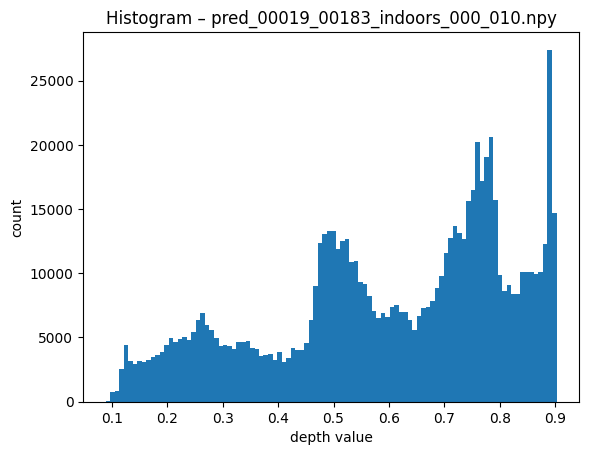

In [ ]:
import os, glob, numpy as np, pandas as pd, matplotlib.pyplot as plt
#from ace_tools import display_dataframe_to_user   # available inside ChatGPT notebooks; ignore if not

# 🔧 1 ‑‑‑‑‑ Edit this to point at the folder that holds your *.npy depth predictions
directory_path = "/tmp/marigold_smoke/indoors1/scene_00019/scan_00183"

# ---------------------------------------------------------------------------
# 2 ‑‑‑‑‑ No changes needed below this line
# ---------------------------------------------------------------------------
file_pattern = os.path.join(directory_path, "*.npy")
file_list   = sorted(glob.glob(file_pattern))
if not file_list:
    raise FileNotFoundError(f"No .npy files found in {directory_path}")

rows = []
for f in file_list:
    arr_f16 = np.load(f)
    arr     = arr_f16.astype(np.float16)
    rows.append(
        {
            "file": os.path.basename(f),
            "shape": "×".join(map(str, arr.shape)),
            "dtype": str(arr.dtype),
            "min":   float(np.nanmin(arr)),
            "max":   float(np.nanmax(arr)),
            "mean":  float(np.nanmean(arr)),
            "std":   float(np.nanstd(arr)),
            "% zeros": float((arr == 0).sum()  / arr.size * 100),
            "% NaNs":  float(np.isnan(arr).sum() / arr.size * 100),
        }
    )

df = pd.DataFrame(rows)
try:
    display_dataframe_to_user("Prediction statistics", df)
except NameError:
    # fall back to plain print if not running inside ChatGPT / ace_tools
    from tabulate import tabulate
    print(tabulate(df, headers="keys", tablefmt="github"))

# quick‑look histogram of the first file
sample = np.load(file_list[0])
plt.hist(sample.flatten(), bins=100)
plt.title(f"Histogram – {os.path.basename(file_list[0])}")
plt.xlabel("depth value");  plt.ylabel("count")
plt.show()


In [ ]:
f0 = file_list[0]
arr16 = np.load(f0)                 # original float16
arr32 = arr16.astype(np.float32)    # up‑cast

print("dtype =", arr32.dtype,
      "|  min =", arr32.min(),
      "|  max =", arr32.max(),
      "|  mean =", arr32.mean(),
      "|  std =",  arr32.std())


dtype = float32 |  min = 0.08898926 |  max = 0.90234375 |  mean = 0.6008287 |  std = 0.21301217


In [ ]:
from pathlib import Path
import torch, numpy as np
from PIL import Image
from diffusers import DDIMScheduler
from marigold.marigold_depth_pipeline import MarigoldDepthPipeline
from torch import nn
from torch.nn import Parameter

# -------- config ---------
ckpt_dir = Path("/home/abradshaw/marigold_checkpoints/stable-diffusion-2")
img_path = Path("/datasets/abradshaw/marigold_data/hypersim/val/ai_003_010/rgb_cam_00_fr0000.png")
device   = "cuda"                                  # or "cpu"
dtype    = torch.float32
denoise_steps = 4
# -------------------------

# --- optional: use DDIM instead of PNDM -------------
ddim = DDIMScheduler.from_pretrained(ckpt_dir, subfolder="scheduler")

# --- build pipeline (UNet still expects 4ch here) ---
pipe = MarigoldDepthPipeline.from_pretrained(
    ckpt_dir,
    scheduler=ddim,           # drop this arg to stay with PNDM
).to(device, dtype=dtype)

# ------- widen conv_in from 4 → 8 channels ----------
old = pipe.unet.conv_in                        # Conv2d(4 → 320)
w, b = old.weight.data, old.bias.data          # shapes [320,4,3,3] & [320]

new_conv = nn.Conv2d(
    in_channels = 8,
    out_channels= old.out_channels,
    kernel_size = old.kernel_size,
    stride      = old.stride,
    padding     = old.padding,
)
new_conv.weight = Parameter(w.repeat(1, 2, 1, 1) * 0.5)  # duplicate & halve
new_conv.bias   = Parameter(b.clone())

pipe.unet.conv_in = new_conv
pipe.unet.config["in_channels"] = 8
pipe.unet.eval(); pipe.vae.eval()

# ------------------ inference -----------------------
img = Image.open(img_path).convert("RGB")
out = pipe(img,
           denoising_steps=denoise_steps,
           processing_res=0,            # keep native res
           show_progress_bar=False)

print("NaNs :", np.isnan(out.depth_np).sum())
print("range:", out.depth_np.min(), out.depth_np.max())


Loading pipeline components...: 100%|██████████| 3/3 [00:00<00:00, 51.05it/s]


NaNs : 0
range: 0.0 1.0


: 

Shape: (480, 640)
Min depth: 0.0000
Max depth: 1.0000
Mean depth: 0.4578
Median depth: 0.3917
Std dev: 0.2675


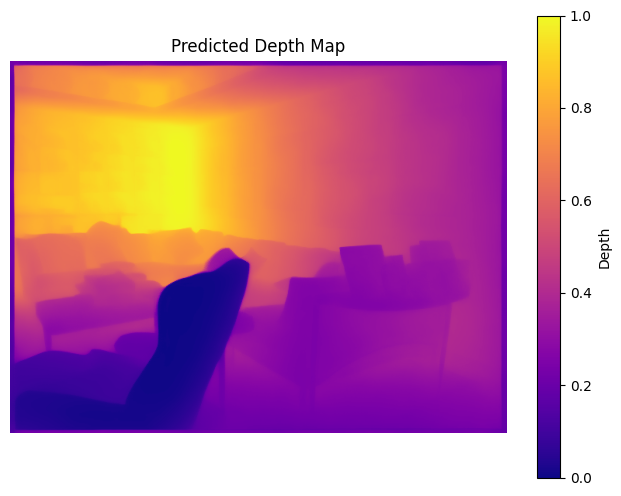

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the Marigold depth prediction
depth_path = "/home/abradshaw/Marigold/output/eval/nyu_test/prediction/test/living_room_0053/pred_1291.npy"
depth = np.load(depth_path)

# Check shape and confirm it's a depth map
print(f"Shape: {depth.shape}")
assert depth.shape == (480, 640), "Unexpected depth shape!"

# Summary statistics
print(f"Min depth: {depth.min():.4f}")
print(f"Max depth: {depth.max():.4f}")
print(f"Mean depth: {depth.mean():.4f}")
print(f"Median depth: {np.median(depth):.4f}")
print(f"Std dev: {depth.std():.4f}")

# Optional: visualize the depth map
plt.figure(figsize=(8, 6))
plt.imshow(depth, cmap='plasma')
plt.title("Predicted Depth Map")
plt.colorbar(label='Depth')
plt.axis('off')
plt.show()


In [2]:
from diffusers import UNet2DConditionModel
import torch, json, pathlib, pprint

REF = "prs-eth/marigold-depth-v1-1"
EXP = "/home/abradshaw/Marigold/output/iter_000000"          # <- point to the UNet folder you saved

ref = UNet2DConditionModel.from_pretrained(REF, subfolder="unet")
exp = UNet2DConditionModel.from_pretrained(EXP, subfolder="unet")

mismatch = {}
for (n_r, p_r), (n_e, p_e) in zip(ref.state_dict().items(), exp.state_dict().items()):
    if p_r.shape != p_e.shape:
        mismatch[n_r] = (tuple(p_r.shape), tuple(p_e.shape))

print(f"# mismatched tensors: {len(mismatch)}")
pprint.pp(mismatch)        # empty dict == good


OSError: We couldn't connect to 'https://huggingface.co' to load this model, couldn't find it in the cached files and it looks like /home/abradshaw/Marigold/output/iter_000000 is not the path to a directory containing a config.json file.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/diffusers/installation#offline-mode'.

In [ ]:

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# ------------ 0. Edit these two lines ----------------------------------
SNAP = "9571e7123e258cf052b4e54241f17971c290e9a8" 
REF_CKPT = f"/home/abradshaw/.cache/huggingface/hub/" \
           f"models--prs-eth--marigold-depth-v1-1/snapshots/{SNAP}"
NEW_UNET  = "./output/train_marigold_depth/checkpoint/latest/unet/" \
            "diffusion_pytorch_model.safetensors"       # trainer‑written weights
# -----------------------------------------------------------------------

import hashlib, torch, numpy as np
from diffusers import UNet2DConditionModel
from safetensors.torch import load_file as load_safetensors

def md5(t):                # quick fingerprint
    return hashlib.md5(t.detach().cpu().numpy().tobytes()).hexdigest()

print("⚠️  Loading checkpoints …")
ref_unet  = UNet2DConditionModel.from_pretrained(f"{REF_CKPT}/unet",
                                                 torch_dtype=torch.float32,
                                                 local_files_only=True)
new_state = load_safetensors(NEW_UNET, device="cpu")

# ── 1) simple hash comparison ──────────────────────────────────────────
h_ref = md5(ref_unet.state_dict()["conv_in.weight"][:5])
h_new = md5(new_state["conv_in.weight"][:5])
print(f"hash(conv_in.weight[:5])  reference = {h_ref}")
print(f"hash(conv_in.weight[:5])  new       = {h_new}")

# ── 2) global change metric ────────────────────────────────────────────
if h_ref == h_new:
    print("🔥  The saved UNet is **bit‑identical** to the reference!  "
          "Either training hasn’t updated the weights yet, or you copied "
          "the wrong folder.")
else:
    l2_diff, l2_ref = 0.0, 0.0
    for k, w_ref in ref_unet.state_dict().items():
        w_new = new_state[k]
        l2_diff += torch.sum((w_ref - w_new) ** 2).item()
        l2_ref  += torch.sum(w_ref ** 2).item()
    rel_change = (l2_diff / l2_ref) ** 0.5
    print(f"✅  UNet hash differs. Overall Δ (relative L2): {rel_change:.4f}")

    


⚠️  Loading checkpoints …
hash(conv_in.weight[:5])  reference = 8c014793d95052c4a422c3bd30a1412d
hash(conv_in.weight[:5])  new       = a250c0a6364a712d9ffa93ba20cf9f3d
✅  UNet hash differs. Overall Δ (relative L2): 0.3070


In [4]:
# ─────────────────────────────────────────────────
SNAP        = "9571e7123e258cf052b4e54241f17971c290e9a8"
REF_UNET    = f"/home/abradshaw/.cache/huggingface/hub/" \
              f"models--prs-eth--marigold-depth-v1-1/snapshots/{SNAP}/unet"
NEW_UNET    = "./output/train_marigold_depth/checkpoint/latest/unet/" \
              "diffusion_pytorch_model.safetensors"
# ─────────────────────────────────────────────────────────────────────────

import torch, numpy as np, pandas as pd
from diffusers import UNet2DConditionModel
from safetensors.torch import load_file as load_safetensors

# 1) load weights  ────────────────────────────────────────────────────────
ref = UNet2DConditionModel.from_pretrained(
        REF_UNET, torch_dtype=torch.float32, local_files_only=True
      ).state_dict()

new = load_safetensors(NEW_UNET, device="cpu")

# 2) per‑layer stats  ─────────────────────────────────────────────────────
rows = []
for name, w_ref in ref.items():
    w_new  = new[name]
    delta  = (w_ref - w_new).float()

    def stats(t):
        return [t.mean().item(), t.std().item(),
                t.min().item(), t.max().item()]

    rows.append([
        name, w_ref.numel(),
        *stats(w_ref),            # μ σ min max  (reference)
        *stats(w_new),            # μ σ min max  (new)
        *stats(delta.abs())       # μ σ min max  (|Δ|)
    ])

cols = ["layer", "param_count",
        "μ_ref", "σ_ref", "min_ref", "max_ref",
        "μ_new", "σ_new", "min_new", "max_new",
        "μ_|Δ|", "σ_|Δ|", "min_|Δ|", "max_|Δ|"]

df = pd.DataFrame(rows, columns=cols)

# 3) flag suspicious layers  ─────────────────────────────────────────────
SIGMA_LIMIT = 2      # > 2× global σ is unusual
DELTA_LIMIT = 1e-2   # any element that moves by >1e‑2
ABS_LIMIT   = 1e1    # weights with |value| > 10

global_sigma = df["σ_ref"].mean()
flags = []

for _, r in df.iterrows():
    issues = []
    if abs(r["max_new"]) > ABS_LIMIT or abs(r["min_new"]) > ABS_LIMIT:
        issues.append("⚠ large magnitude")
    if r["σ_new"] > SIGMA_LIMIT * global_sigma:
        issues.append("⚠ high σ")
    if r["max_|Δ|"] > DELTA_LIMIT:
        issues.append("⚠ big change")
    if np.isnan(r[["μ_new","σ_new","min_new","max_new"]].astype(float).to_numpy()).any():
        issues.append("❌ NaN/Inf")
    if issues:
        flags.append((r["layer"], ", ".join(issues)))

print("=== Suspicious layers =================================================")
for name, why in flags:
    print(f"{name:60s}  {why}")
print("======================================================================\n")

# 4) show 20 biggest single‑element changes  ─────────────────────────────
pd.set_option("display.max_columns", None)
display(df.sort_values("max_|Δ|", ascending=False).head(20))


=== Suspicious layers =================================================
conv_in.weight                                                ⚠ big change
conv_in.bias                                                  ⚠ big change
time_embedding.linear_1.weight                                ⚠ big change
time_embedding.linear_1.bias                                  ⚠ big change
time_embedding.linear_2.weight                                ⚠ big change
time_embedding.linear_2.bias                                  ⚠ big change
down_blocks.0.attentions.0.norm.weight                        ⚠ big change
down_blocks.0.attentions.0.norm.bias                          ⚠ big change
down_blocks.0.attentions.0.proj_in.weight                     ⚠ big change
down_blocks.0.attentions.0.proj_in.bias                       ⚠ big change
down_blocks.0.attentions.0.transformer_blocks.0.norm1.weight  ⚠ big change
down_blocks.0.attentions.0.transformer_blocks.0.norm1.bias    ⚠ big change
down_blocks.0.attentions.0.t

,layer,param_count,μ_ref,σ_ref,min_ref,max_ref,μ_new,σ_new,min_new,max_new,μ_|Δ|,σ_|Δ|,min_|Δ|,max_|Δ|
579,up_blocks.3.attentions.2.transformer_blocks.0....,320,0.024018,0.133561,-0.303386,1.579281,0.012923,0.057234,-0.216770,0.213553,0.033848,0.135310,2.714805e-06,1.790283
553,up_blocks.3.attentions.1.transformer_blocks.0....,320,-0.031759,0.161955,-1.620620,1.262874,-0.018471,0.094012,-0.385624,0.281963,0.048523,0.138026,3.356487e-05,1.665616
580,up_blocks.3.attentions.2.transformer_blocks.0....,102400,-0.000386,0.161379,-1.459340,1.528667,-0.000151,0.111513,-0.650104,0.545257,0.053955,0.075010,1.244247e-06,1.542064
581,up_blocks.3.attentions.2.transformer_blocks.0....,102400,0.000459,0.127889,-1.720424,1.710349,0.000108,0.101500,-0.977135,0.952446,0.029480,0.042302,3.352761e-08,1.012626
372,up_blocks.1.resnets.0.time_emb_proj.weight,1638400,0.000016,0.009888,-3.386188,0.859903,0.000011,0.008133,-2.853139,0.537161,0.004040,0.004058,0.000000e+00,0.741688
555,up_blocks.3.attentions.1.transformer_blocks.0....,102400,0.000256,0.135544,-1.308942,1.009944,0.000029,0.119611,-0.718262,0.736607,0.026399,0.031781,7.776543e-07,0.739738
554,up_blocks.3.attentions.1.transformer_blocks.0....,102400,0.000220,0.157942,-0.898885,0.970055,0.000230,0.126508,-0.549355,0.635191,0.046284,0.047726,5.811453e-07,0.610804
683,conv_norm_out.bias,320,-0.168942,0.690046,-4.560919,0.118398,-0.186653,0.751935,-5.129172,0.129156,0.024259,0.068947,1.616031e-05,0.568253
682,conv_norm_out.weight,320,0.286581,0.324463,-0.002230,2.663415,0.307049,0.358599,-0.000237,3.189737,0.024896,0.047364,3.640354e-05,0.526322
224,down_blocks.2.resnets.1.time_emb_proj.weight,1638400,0.000120,0.009281,-2.231521,0.413346,0.000158,0.007330,-1.829977,0.318263,0.004792,0.004223,9.313226e-10,0.401544


                                                 layer  param_count  \
286         up_blocks.0.resnets.2.conv_shortcut.weight      3276800   
579  up_blocks.3.attentions.2.transformer_blocks.0....          320   
274         up_blocks.0.resnets.1.conv_shortcut.weight      3276800   
685                                      conv_out.bias            4   
553  up_blocks.3.attentions.1.transformer_blocks.0....          320   
148       down_blocks.1.resnets.1.time_emb_proj.weight       819200   
4                       time_embedding.linear_2.weight      1638400   
72        down_blocks.0.resnets.1.time_emb_proj.weight       409600   
616         up_blocks.3.resnets.1.time_emb_proj.weight       409600   
512         up_blocks.2.resnets.2.time_emb_proj.weight       819200   
604         up_blocks.3.resnets.0.time_emb_proj.weight       409600   
500         up_blocks.2.resnets.1.time_emb_proj.weight       819200   
628         up_blocks.3.resnets.2.time_emb_proj.weight       409600   
288   

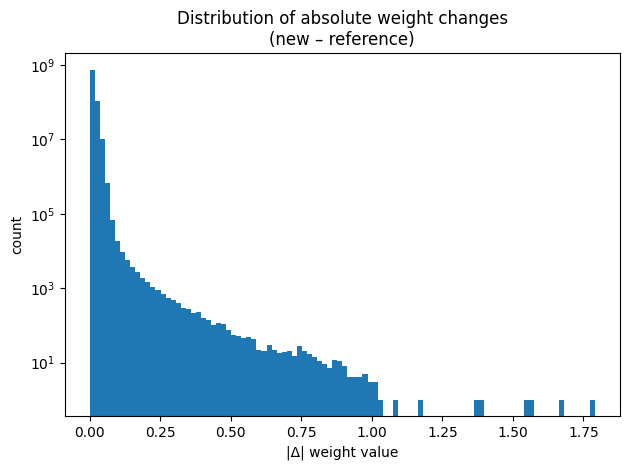

In [ ]:
# ╭─────────────────────────── EDIT PATHS IF NEEDED ─────────────────────╮
SNAP  = "9571e7123e258cf052b4e54241f17971c290e9a8"
REF   = f"/home/abradshaw/.cache/huggingface/hub/" \
        f"models--prs-eth--marigold-depth-v1-1/snapshots/{SNAP}/unet"
NEW   = "./output/train_marigold_depth/checkpoint/latest/unet/" \
        "diffusion_pytorch_model.safetensors"
THRESH = 1e-5        # any element that moved by >THRESH counts as 'changed'
# ╰───────────────────────────────────────────────────────────────────────╯

import torch, numpy as np, pandas as pd
from diffusers import UNet2DConditionModel
from safetensors.torch import load_file as load_st

ref = UNet2DConditionModel.from_pretrained(REF, torch_dtype=torch.float32,
                                           local_files_only=True).state_dict()
new = load_st(NEW, device="cpu")

rows = []
for k, w_ref in ref.items():
    w_new = new[k]
    diff  = (w_ref - w_new).float()
    rel_l2 = torch.linalg.vector_norm(diff) / torch.linalg.vector_norm(w_ref)
    frac_moved = (diff.abs() > THRESH).sum().item() / diff.numel()
    rows.append((k, w_ref.numel(), rel_l2.item(), frac_moved))

df = pd.DataFrame(rows, columns=["layer", "param_count",
                                 "rel_L2_change", f"frac_|Δ|>{THRESH}"])
pd.set_option("display.precision", 4)
print(df.sort_values("rel_L2_change", ascending=False).head(15))


# ── print the 15 most‑changed layers (already in your code) ─────────────
print(df.sort_values("rel_L2_change", ascending=False).head(15))

# ╭───────────────── NEW: DISTRIBUTION COMPARISON ─────────────────╮
# gather *all* absolute weight differences into one big vector
all_diffs = torch.cat([(ref[k] - new[k]).view(-1).abs() for k in ref])

# quick numeric summary
q = np.percentile(all_diffs.numpy(), [0, 25, 50, 75, 90, 95, 99, 100])
print("\nAbsolute |Δ| statistics across the whole UNet")
print(" min  {:9.6f}".format(q[0]))
print(" 25%  {:9.6f}".format(q[1]))
print(" median{:9.6f}".format(q[2]))
print(" 75%  {:9.6f}".format(q[3]))
print(" 90%  {:9.6f}".format(q[4]))
print(" 95%  {:9.6f}".format(q[5]))
print(" 99%  {:9.6f}".format(q[6]))
print(" max  {:9.6f}".format(q[7]))

# optional: visualise with a histogram  (one plot, no colour spec)
import matplotlib.pyplot as plt

plt.figure()
plt.hist(all_diffs.numpy(), bins=100, log=True)
plt.xlabel("|Δ| weight value")
plt.ylabel("count")
plt.title("Distribution of absolute weight changes\n(new – reference)")
plt.tight_layout()
plt.show()
# ╰────────────────────────────────────────────────────────────────╯



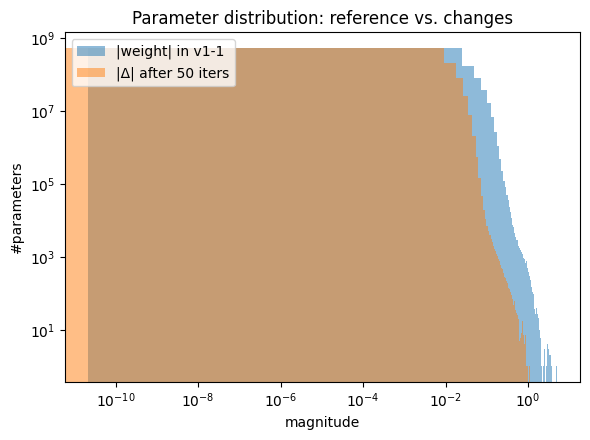

In [ ]:
import torch, numpy as np, matplotlib.pyplot as plt
from diffusers import UNet2DConditionModel
from safetensors.torch import load_file as load_st

# ────────────────────────────────────────────────
SNAP  = "9571e7123e258cf052b4e54241f17971c290e9a8"
REF   = f"/home/abradshaw/.cache/huggingface/hub/" \
        f"models--prs-eth--marigold-depth-v1-1/snapshots/{SNAP}/unet"
NEW   = "./output/train_marigold_depth/checkpoint/latest/unet/" \
        "diffusion_pytorch_model.safetensors"
# ───────────────────────────────────────────────────────────────────────

ref = UNet2DConditionModel.from_pretrained(REF, local_files_only=True).state_dict()
new = load_st(NEW, device="cpu")

abs_ref  = torch.cat([w.abs().view(-1)             for w in ref.values()]).numpy()
abs_diff = torch.cat([(w - new[k]).abs().view(-1)  for k, w in ref.items()]).numpy()

fig, ax = plt.subplots(figsize=(6,4.5))
ax.hist(abs_ref , bins=200, alpha=.5, label="|weight| in v1‑1")
ax.hist(abs_diff, bins=200, alpha=.5, label="|Δ| after 50 iters")
ax.set_xscale("log"); ax.set_yscale("log")
ax.set_xlabel("magnitude"); ax.set_ylabel("#parameters")
ax.set_title("Parameter distribution: reference vs. changes")
ax.legend(); plt.tight_layout()


In [15]:
import torch, hashlib
from diffusers import UNet2DConditionModel
from safetensors.torch import load_file as load_st


# ----- edit paths -----------------------------------------------------
BASE = "/home/abradshaw/marigold_checkpoints/stable-diffusion-2/unet/"
MARI = REF
YOUR = NEW
# ---------------------------------------------------------------------

ADAPT_CONV_IN = True          # False → just skip conv_in, True → widen it
# ───────────────────────────────────────────────────────────────────────

def widen_sd_conv4_to8(w):
    """duplicate 4‑ch → 8‑ch and halve magnitude"""
    return (w.repeat(1, 2, 1, 1) * 0.5).clone()

def rel_L2(A, B):
    num, den = 0.0, 0.0
    for k, wB in B.items():
        wA = A.get(k)
        if wA is None:                       # should not happen
            continue
        if wA.shape != wB.shape:
            if "conv_in.weight" in k and ADAPT_CONV_IN:
                wB = widen_sd_conv4_to8(wB)  # make shapes match
            else:
                # shapes differ and we don't adapt → skip this tensor
                continue
        num += torch.sum((wA - wB) ** 2).item()
        den += torch.sum(wB ** 2).item()
    return (num / den) ** 0.5

print("Loading checkpoints …")
sd   = UNet2DConditionModel.from_pretrained(BASE, local_files_only=True).state_dict()
mari = UNet2DConditionModel.from_pretrained(MARI, local_files_only=True).state_dict()
your = load_st(YOUR, device="cpu")

print(f"Δ_B→Y  = {rel_L2(your, sd  ):6.3f}   (# steps done so far)")
print(f"Δ_M→Y  = {rel_L2(your, mari):6.3f}   (how far from v1‑1)")
print(f"Δ_B→M  = {rel_L2(mari, sd  ):6.3f}   (full journey v1‑1 made)")
print(f"Δ_B→M  = {l2_distance(mari, sd2):.3f}")


Loading checkpoints …
Δ_B→Y  =  0.002   (# steps done so far)
Δ_M→Y  =  0.307   (how far from v1‑1)
Δ_B→M  =  0.307   (full journey v1‑1 made)


RuntimeError: The size of tensor a (8) must match the size of tensor b (4) at non-singleton dimension 1

In [1]:
import torch, numpy as np
from pathlib import Path
from tqdm import tqdm
from marigold.marigold_depth_pipeline import MarigoldDepthPipeline
from torch import nn
from torch.nn import Parameter
from src.trainer.marigold_depth_trainer import MarigoldDepthTrainer


# ---------- 0.  plumbing -------------------------------------------------
device   = "cuda"
trainer  = MarigoldDepthTrainer(cfg, model, train_dataloader, device, out_dir_ckpt, out_dir_eval, out_dir_vis, accumulation_steps)
vae      = trainer.model.vae.to(device)
dl       = trainer.train_loader      # pick any loader you like

vae.eval()
with torch.no_grad():

    # ---------- 1.  grab one batch --------------------------------------
    batch          = next(iter(dl))
    rgb_norm       = batch["rgb_norm"].to(device)         # [-1,1]
    depth_raw      = batch[trainer.gt_depth_type].to(device)
    valid_mask     = batch[trainer.gt_mask_type].to(device)

    print("raw depth stats :", depth_raw.min().item(),
                              depth_raw.max().item(),
                              torch.median(depth_raw).item())

    # ---------- 2.  depth normalisation ---------------------------------
    q02, q98 = torch.quantile(depth_raw[valid_mask], q=(.02, .98))
    depth_norm = (depth_raw - q02) / (q98 - q02)          # → [0,1]
    depth_norm = depth_norm.clamp(0, 1) * 2 - 1           # → [-1,1]

    print("depth_norm  ∈ [{:.2f},{:.2f}]".format(
            depth_norm.min().item(), depth_norm.max().item()))

    # ---------- 3.  VAE round‑trip error -------------------------------
    def vae_encode(img):                          # img ∈ [-1,1]
        h      = vae.encoder(img)
        mean   = vae.quant_conv(h).chunk(2, dim=1)[0]
        return mean * trainer.model.latent_scale_factor

    def vae_decode(lat):                          # lat in latent space
        z      = vae.post_quant_conv(lat / trainer.model.latent_scale_factor)
        rec    = vae.decoder(z).mean(1, keepdim=True)
        return rec

    depth_lat   = vae_encode(depth_norm)
    depth_rec   = vae_decode(depth_lat)
    l1_err      = (depth_rec - depth_norm).abs()[valid_mask].mean().item()

    print(f"VAE round‑trip L1 error : {l1_err:.4e}")

    # ---------- 4.  UNet+scheduler sanity on *this* batch ---------------
    # build the same latents the trainer uses
    rgb_lat    = vae_encode(rgb_norm)
    noise      = torch.randn_like(depth_lat)
    t          = torch.randint(0,
                               trainer.model.scheduler.num_train_timesteps,
                               (1,), device=device)

    noisy_lat  = trainer.training_noise_scheduler.add_noise(depth_lat,
                                                            noise, t)
    cat_lat    = torch.cat([rgb_lat, noisy_lat], 1).float()

    # forward UNet in full FP‑32 to see the raw output distribution
    with torch.autocast("cuda", enabled=False):
        pred = trainer.model.unet(cat_lat, t,
                                  trainer.model.fixed_embed.expand(1,-1,-1)
                                  ).sample
    print("UNet pred   stats :", pred.min().item(),
                                pred.max().item(),
                                torch.mean(torch.isfinite(pred).float()).item())


/home/abradshaw/Marigold/venv/marigold/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'cfg' is not defined